# Further Validation and Inference

In this notebook, we aim to further evaluate the model’s performance by exploring additional validation and inference techniques. Although the initial evaluation yielded promising results, conducting more robust validation will help us gain deeper insights into the model's generalization capabilities.

### Approaches for Extended Validation

1. **Cross-Validation with K-Fold**:  
   Cross-validation is a commonly used technique to validate a model’s performance across multiple subsets of the data. In this approach, the dataset is divided into `K` equal folds, and the model is trained and evaluated `K` times, each time using a different fold as the validation set while the remaining folds serve as the training set. This method helps us:
   - Obtain a more reliable estimate of the model’s performance across different subsets of data.
   - Identify any potential overfitting by analyzing the variance in performance across folds.
   
   Although K-Fold cross-validation is not implemented in this notebook, it’s a recommended approach for further rigorous validation if we have enough data.

2. **Synthetic Dataset Generation Using Large Language Models (LLMs)**:  
   To further test the model’s robustness and performance, we propose creating a synthesized dataset using a Large Language Model (LLM). By using prompts tailored to our data characteristics, we can generate additional data points that simulate real-world scenarios. This synthesized data will provide a new source for testing, enabling us to:
   - Evaluate the model’s performance on unseen, diverse data, thereby testing its generalization to novel inputs.
   - Increase the dataset size for validation without the need for additional real-world data collection.
   
   Leveraging LLMs for data augmentation allows us to create a wide variety of examples that may capture nuances not present in the original dataset, thereby enhancing the evaluation process.

### Goals of Further Validation and Testing

- **Improved Generalization Insight**: Using synthetic data and cross-validation will help us understand the model’s behavior across a broader range of data distributions.
- **Identify Potential Model Weaknesses**: By challenging the model with diverse synthesized examples, we can reveal areas where the model may need improvement or fine-tuning.
- **Broader Inference Testing**: With an expanded dataset, we can explore more complex inference scenarios, making the model evaluation more comprehensive.

### Next Steps

- Use prompt-based techniques to generate synthetic data similar to the original dataset.
- Evaluate the model on this synthesized dataset and analyze the results.
- Optionally, implement K-Fold cross-validation in future notebooks for a more thorough validation process.

By following these steps, we aim to build a stronger understanding of the model’s capabilities and potential limitations, ultimately leading to a more robust and reliable model.

### Import Libraries

In [57]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve
from datasets import Dataset
import os
import openai
import json
import re
import string
import matplotlib.pyplot as plt
from dotenv import load_dotenv
load_dotenv()


True

In [6]:
openai.api_key = os.getenv("OPENAI_API_KEY")

### Define the Prompt
You probably need some prompt engineering works to make sure the prompt can help you to generate the expected content in apporpriate format. Youl also can try the synthesized data I saved under the folder `../data/synthesized/`

In [33]:
reviews_generation_prompt = '''Generate 100 customer reviews for a restaurant, with 50 positive reviews and 50 negative reviews.

- Positive Reviews: Each review should express satisfaction with the restaurant's food, service, ambiance, or overall experience. The style should be a mix of formal and casual language, with both short and long sentences. Some reviews can be enthusiastic, while others can be more reserved but still positive. Here are some examples for reference:
    - "The food was absolutely delicious! I can't wait to come back."
    - "A wonderful dining experience. The ambiance was cozy, and the staff were attentive."
    - "Amazing service and fantastic food! Loved every dish we tried."
    - "I enjoyed the atmosphere and the food. Highly recommended!"
    - "Best meal I've had in a long time. The flavors were incredible, and the presentation was stunning."

- Negative Reviews: Each review should express disappointment with the food, service, ambiance, or overall experience. The style should also be a mix of formal and casual language, with both short and long sentences. Some reviews can be mildly disappointed, while others can express stronger dissatisfaction. Here are some examples for reference:
    - "The food was cold, and the service was slow. Not impressed."
    - "I was really looking forward to this place, but it didn't live up to the hype."
    - "Unfortunately, the dishes were bland, and the portions were small."
    - "I expected more given the high prices. Won't be coming back."
    - "The ambiance was nice, but the food and service left much to be desired."
Generate 50 unique positive reviews and 50 unique negative reviews, and return them in the following raw JSON format which is ready for programming:
{
    "positive_reviews": [list of positive reviews],
    "negative_reviews": [list of negative reviews]
}
'''

In [40]:

def generate_synthetic_reviews():
    response = openai.ChatCompletion.create(
        model="gpt-4o",  
        messages=[{"role": "system", "content": reviews_generation_prompt}],
        max_tokens=3500,
        temperature=0.7
    )
    
    response_text = response.choices[0].message['content'].strip()
    clean_text = re.sub(r'```json|```', '', response_text).strip()
    positive_reviews, negative_reviews = [], []

    try:
        review_data = json.loads(clean_text)
        positive_reviews = review_data.get("positive_reviews", [])
        negative_reviews = review_data.get("negative_reviews", [])
    except json.JSONDecodeError as e:
        print("Error decoding JSON:", e)
        return None, None
    
    # Return the generated lists
    return positive_reviews, negative_reviews

In [41]:
positive_reviews, negative_reviews = generate_synthetic_reviews()
print(f"Sample Positive Review: {positive_reviews[0]} with {len(positive_reviews)} reviews")
print(f"Sample Negative Review:{negative_reviews[0]} with {len(negative_reviews)} reviews")

```json
{
    "positive_reviews": [
        "The food was absolutely delicious! I can't wait to come back.",
        "A wonderful dining experience. The ambiance was cozy, and the staff were attentive.",
        "Amazing service and fantastic food! Loved every dish we tried.",
        "I enjoyed the atmosphere and the food. Highly recommended!",
        "Best meal I've had in a long time. The flavors were incredible, and the presentation was stunning.",
        "Our waiter was so friendly and made great recommendations. The dessert was my favorite part!",
        "The atmosphere was vibrant, and the food was mouth-watering. I'll definitely return soon.",
        "A delightful place to dine. The chef's special was a culinary masterpiece.",
        "Service was impeccable, and the drinks were expertly crafted. A true gem!",
        "From start to finish, everything was perfect. Can't wait to bring my friends here.",
        "The decor is beautiful, and the food matches it in quality. Ver

### Save the Synthesized Data for Use

In [42]:
# Create a DataFrame for positive and negative reviews
positive_df = pd.DataFrame({"Review": positive_reviews, "Liked": 1})
negative_df = pd.DataFrame({"Review": negative_reviews, "Liked": 0})

# Concatenate both DataFrames
synthesized_df = pd.concat([positive_df, negative_df], ignore_index=True)

# Define the save path and ensure the directory exists
save_path = "../data/synthesized"
os.makedirs(save_path, exist_ok=True)

# Save the DataFrame as a CSV file
csv_file_path = os.path.join(save_path, "synthesized_reviews.csv")
synthesized_df.to_csv(csv_file_path, index=False)


### Preprocess the Synthesized Dataset

In [45]:
# remember the helper function we have already been used earlier
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove newlines and extra whitespace
    text = ' '.join(text.split())
    
    return text
def process_raw_data(df):
    # Apply preprocess_text function to the 'Review' column
    df['Review'] = df['Review'].apply(lambda x: preprocess_text(x))
    return df

In [46]:
processed_synthesized_df = process_raw_data(synthesized_df)

In [47]:
processed_synthesized_df.head()

,Review,Liked
0,the food was absolutely delicious i cant wait ...,1
1,a wonderful dining experience the ambiance was...,1
2,amazing service and fantastic food loved every...,1
3,i enjoyed the atmosphere and the food highly r...,1
4,best meal ive had in a long time the flavors w...,1


### Format the Synthesized Dataset Format and Tokenize

In [48]:
processed_synthesized_df['labels'] = processed_synthesized_df['Liked']

test_synthesized_dataset = Dataset.from_pandas(processed_synthesized_df)

# Load tokenizer and model
# Load the fine-tuned model and tokenizer
model_path = '../data/models/bert-base-uncased_v1'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

In [49]:
# Tokenize helper function again
def tokenize_function(examples):
    # Tokenize the 'Review' column
    tokenized = tokenizer(examples['Review'], padding='max_length', truncation=True)
    # Include 'labels' in the tokenized output if available
    tokenized['labels'] = examples['labels']
    return tokenized

In [52]:
test_synthesized_dataset = test_synthesized_dataset.map(tokenize_function, batched=True)
test_synthesized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map: 100%|██████████| 100/100 [00:00<00:00, 1237.75 examples/s]


In [53]:
# Ensure the model is on the CPU
model = model.to("cpu")

training_args = TrainingArguments(
    output_dir=model_path,
    per_device_eval_batch_size=16,
    no_cuda=True
)

# Initialize the Trainer instance with CPU-only settings
trainer = Trainer(
    model=model,
    args=training_args
)


### Matrics Evaluation

In [55]:
# Perform prediction on the test dataset
predictions = trainer.predict(test_synthesized_dataset)

# Extract logits (raw scores) from predictions
logits = predictions.predictions

# Apply softmax to get probabilities for each class
probs = torch.softmax(torch.tensor(logits), dim=1)

# Get the predicted labels by taking the class with the highest probability
predicted_labels = torch.argmax(probs, axis=1).numpy() 

# Convert predictions to a list and add as a new column to test_df
processed_synthesized_df['Predicted'] = predicted_labels 
processed_synthesized_df['Probability_Positive'] = probs[:, 1].numpy() # Probability of the positive class 1

# Display the first few rows to compare actual vs. predicted
print(processed_synthesized_df[['Review', 'Liked', 'Predicted']].head())

                                              Review  Liked  Predicted
0  the food was absolutely delicious i cant wait ...      1          1
1  a wonderful dining experience the ambiance was...      1          1
2  amazing service and fantastic food loved every...      1          1
3  i enjoyed the atmosphere and the food highly r...      1          1
4  best meal ive had in a long time the flavors w...      1          1


In [56]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(processed_synthesized_df['Liked'], processed_synthesized_df['Predicted'])

# Calculate accuracy
accuracy = accuracy_score(processed_synthesized_df['Liked'], processed_synthesized_df['Predicted'])

print("Confusion Matrix:")
print(conf_matrix)
print("\nAccuracy:", accuracy)

Confusion Matrix:
[[49  1]
 [ 1 49]]

Accuracy: 0.98


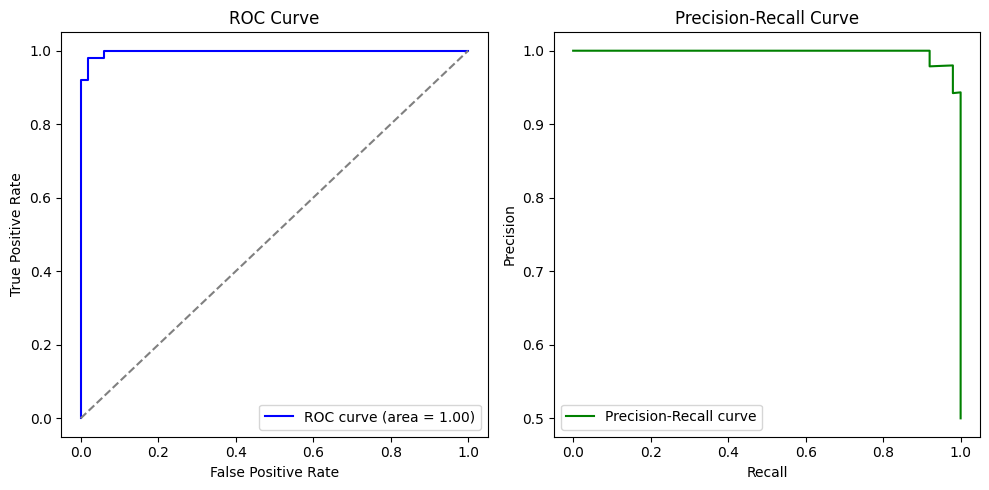

In [59]:
# Now calculate the ROC and Precision-Recall curves using the positive class probabilities
fpr, tpr, _ = roc_curve(processed_synthesized_df['Liked'], processed_synthesized_df['Probability_Positive'])
roc_auc = auc(fpr, tpr)
# Plot ROC Curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(processed_synthesized_df['Liked'], processed_synthesized_df['Probability_Positive'])
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

In [65]:
model_path = '../data/models/bert-base-uncased_v1'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

# Set the model to evaluation mode
model.eval()

text = "The food was amazing and the service was fantastic!"

# Tokenize the input text
inputs = tokenizer(text, return_tensors="pt")

# Get the model's prediction
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Convert logits to probabilities
probs = torch.softmax(logits, dim=1)

# Get the predicted label (0 for negative, 1 for positive)
predicted_label = torch.argmax(probs).item()
confidence = probs[0][predicted_label].item()
predicted_label,confidence

(1, 0.97226881980896)

# Conclusion

Our sentiment analysis model achieved an impressive **98% accuracy** on the synthesized dataset, demonstrating good generalizability for this binary classification task in sentiment analysis. This high accuracy indicates that the model is effective at distinguishing between positive and negative sentiments, even on data that wasn't part of the original training set.

Given this performance, we can proceed to the next step of deploying the model in a simple web application. This application will allow users to input text (e.g., customer reviews) and receive real-time predictions on the sentiment, providing a practical and interactive demonstration of the model's capabilities.

Implementing the model in a web app will make it more accessible and user-friendly, enabling broader testing and usability in various scenarios related to customer sentiment.